# Persistence analysis

En este proyecto se utilizarán herramientas de visualización/exploración de datos: encaje de Takens, complejos simpliciales, homología persistente, diagramas persistentes, códigos de barras, diagramas de densidad e imágenes de persistencia para estudiar una serie de tiempo.

Realizaremos un análisis exploratorio del conjunto de datos proporcionado. El objetivo es comprender y poder explicar los patrones que observa en el conjunto de datos.
Entrega un reporte 

### Import libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import matplotlib
import seaborn as sb
import matplotlib.cm as cm
plt.rcParams.update(plt.rcParamsDefault)
#from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
#from gtda.homology import VietorisRipsPersistence
#from gtda.plotting import plot_point_cloud
sb.set(style="whitegrid")

### Data

In [8]:
headers=['Year','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
datos= pd.read_fwf('nino34.long.anom.data.txt', names=headers)
datos = datos.drop(datos.index[-1])
datos

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1870,-1.00,-1.20,-0.83,-0.81,-1.27,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1,1871,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
2,1872,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
3,1873,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
4,1874,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2014,-0.42,-0.45,-0.07,0.28,0.45,0.48,0.13,0.14,0.37,0.48,0.89,0.77
145,2015,0.59,0.57,0.48,0.90,1.04,1.28,1.56,1.87,2.01,2.21,2.57,2.56
146,2016,2.56,2.11,1.60,1.05,0.45,0.06,-0.25,-0.48,-0.46,-0.75,-0.63,-0.51
147,2017,-0.34,-0.01,-0.09,0.22,0.30,0.22,0.22,-0.18,-0.56,-0.52,-0.84,-0.85


### Visualizacion de Series de tiempo

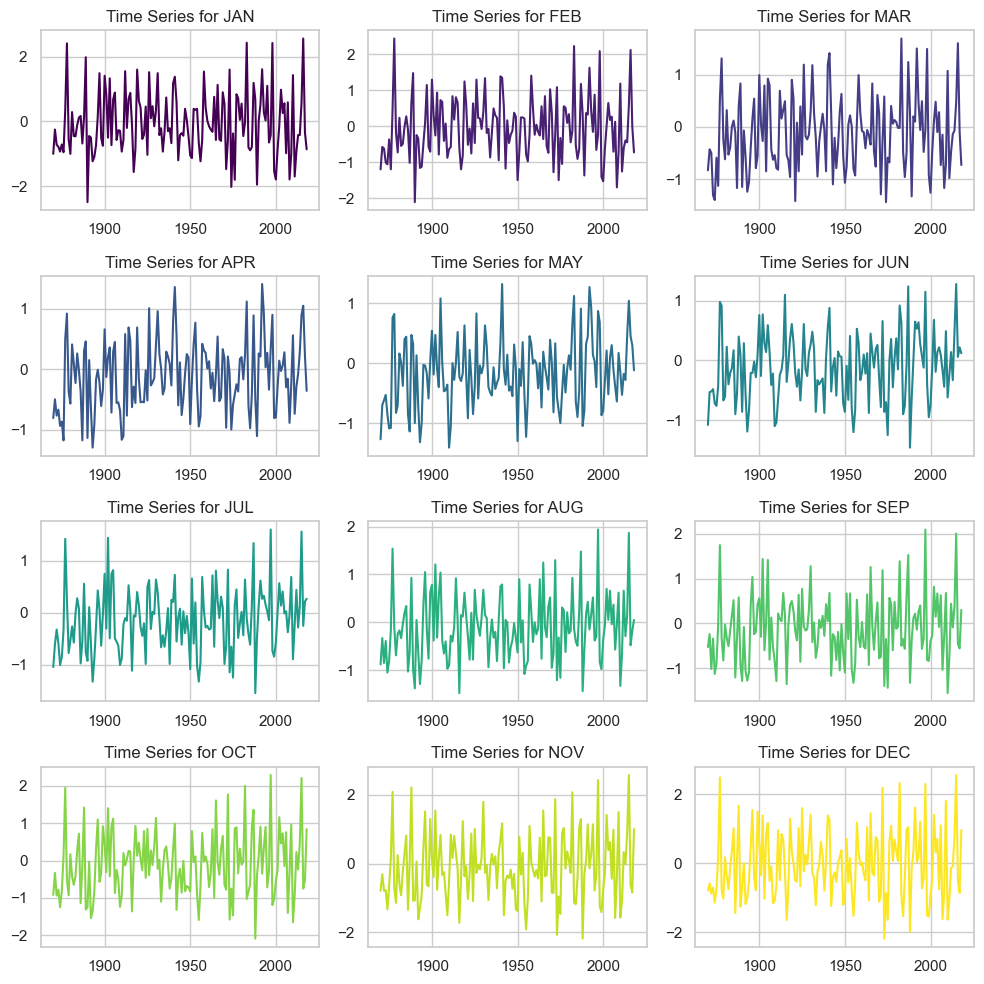

In [24]:


# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows= 4, ncols=3, figsize=(10, 10))
axes = axes.flatten()  # Flatten the array to make indexing easier in a loop
x,y = (datos["Year"],datos.iloc[:,1:])


#colors
cmap =  cm.get_cmap('viridis',12) 
# Plot each column
for i,column in enumerate(y.columns):
    color = cmap(i)
    axes[i].plot(x,y[column],marker="",linestyle="-",color=color)
    axes[i].set_title(f'Time Series for {column}')
    axes[i].grid(True)



# Adjust layout
plt.tight_layout()
plt.show()

### Encaje de Takens

### Complejos simpliciales